In [2]:
#导入需要的包
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms
 
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%matplotlib  inline

In [4]:
image_size=28
num_classes=10
num_epochs=20
batch_size=64

In [5]:
#加载MNIST数据
#用户想调用自己的数据图像时，可以使用torchvision.datasets.ImageFolder
#或torch.utils.data.TensorDataset
train_dataset = dsets.MNIST(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = dsets.MNIST(root='./data',
                            train=False,
                            transform=transforms.ToTensor)

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=batch_size,
                                            shuffle=True)



In [7]:
'''校验集和测试集，校验集用来检测模型，测试机用来检测整个模型的工作'''
#indices，相当于对所有test_dataset中的数据编码
#indice_val 校验集数据的下标，indices_test表示测试集的下标
indices = range(len(test_dataset))
indices_val=indices[:5000]
indices_test=indices[5000:]

In [8]:
#根据下标构造两个数据集的SubsetRandomSampler采样器，它会对下标进行采样
sampler_val=torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test=torch.utils.data.sampler.SubsetRandomSampler(indices_test)

In [9]:
#根据两个采样器定义加载器
'''
采样器：为加载器提供了一个每一批抽取数据集中样本的方法。我们可以按照顺序逐个抽取数据集中的数据到加载器中，
也可以完全的随机地抽取，甚至可以依某种概率抽取。
'''
validation_loader=torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    sampler=sampler_val
)

In [10]:
test_loader=torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    sampler=sampler_test
)

label is: 5


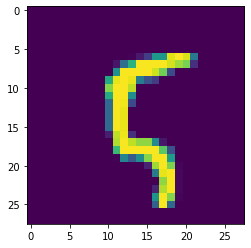

In [11]:
#随便从数据集中读入一张图片，并绘制出来
idx=100
#dataset支持下标索引，其中提取出来的元素为features，target格式，即属性和标签。[0]表示索引features
muteimg=train_dataset[idx][0].numpy()
plt.imshow(muteimg[0,...])
print('label is:',train_dataset[idx][1])

In [12]:
#构建网络
'''
使用nn.Module类  来构建卷积神经网络
'''
depth=[4,8]
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()

        self.conv1=nn.Conv2d(1,4,5,padding=2)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(depth[0],depth[1],5,padding=2)
        self.fc1=nn.Linear(image_size//4*image_size//4*depth[1],512)
        self.fc2=nn.Linear(512,num_classes)

    def forward(self,x):
        x=self.conv1(x) #第一层卷积
        x=F.relu(x) #激活函数，用Relu
        x=self.pool(x) #第二层池化，将图片变小
        x=self.conv2(x) #第三层卷积，窗口为5
        x=F.relu(x) #非线性函数
        x=self.pool(x) #第四层池化，将图片缩小到原来的1/4

        x=x.view(-1,image_size//4*image_size//4*depth[1])
        x=F.relu(self.fc1(x))

        x=F.dropout(x,training=self.training)
        x=self.fc2(x)

        x=F.log_softmax(x,dim=1)
        return x
    
    def retrieve_features(self,x):
        feature_map1 = F.relu(self.conv1(x))
        x=self.pool(feature_map1)
        feture_map2 = F.relu(self.conv2(x))
        return (feature_map1,feature_map2)

In [13]:
 def rightness(output, target):
    preds = output.data.max(dim=1, keepdim=True)[1]
    return preds.eq(target.data.view_as(preds)).cpu().sum(), len(target)
 net = ConvNet()

 criterion = nn.CrossEntropyLoss()
 optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9) #定义优化器，普通的随机梯度下降法

 record = []
 weights = []

 for epoch in range(num_epochs):
     train_rights = []

     for batch_idx,(data,target) in enumerate(train_loader): #针对容器中的每一个批进行循环
         #将Tensor转化为Variable,data为一批图像，target为一批标签
         data,target = Variable(data),Variable(target)
    #给网络模型做标记，标志着模型在训练集上训练
    #这种区分主要是为了打开关闭net的training标志，从而决定是否运行dropout
         net.train()

         output = net(data) #神经网络完成一次前馈的计算过程，得到预测输出output
         loss = criterion(output,target) #将output与标签target比较计算误差
         optimizer.zero_grad() #清空梯度
         loss.backward() #反向传播
         optimizer.step() #一步随机梯度下降算法
         right = rightness(output,target) #计算准确率所需数值，返回数值为
         train_rights.append(right) #将计算结果装到列表容器train_rights中

         if batch_idx % 100 == 0:
             net.eval()
             val_rights=[]

             #开始在校验集上做循环，计算校验集上的准确度
             for (data,target) in validation_loader:
                 data,target = Variable(data),Variable(target)
                 #完成一次前馈计算过程，得到目前训练的模型net在校验集上的表现
                 output=net(data)
                 #计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
                 right =rightness(output,target)
                 val_rights.append(right)

                 train_r = (sum([tup[0] for tup in train_rights]),sum([tup[1] for tup in train_rights]))
                 val_r = (sum([tup[0] for tup in val_rights]),sum([tup[1] for tup in val_rights]))

                 record.append((100-100.*train_r[0]/train_r[1],100-100.*val_r[0]/val_r[1]))
                 weights.append([ne.conv1.weight.data.clone(),net.conv1.bias.data.clone(),
                                net.conv2.weight.data.clone(),net.conv2.bias.data.clone()])


TypeError: object() takes no parameters

In [22]:
net.eval()
vals=[]
for data,target in test_loader:
    data,target = Variable(data,volatile=True),Variable(target)
    output=net(data)
    val=rightness(output,target)
    vals.append(val)

rights=(sum([tup[0] for tup in vals]),sum([tup[1] for tup in vals]))
right_rate=1.0*rights[0]/rights[1]
right_rate

plt.figure(figsize=(10,7))
plt.plot(record) #record记载了每一个打印周期记录的训练集和校验集上的准确度
plt.xlabel('Steps')
plt.ylabel('Error rate')

TypeError: object() takes no parameters